# APS 2

## Importando as bibliotecas necessárias

In [235]:
from math import sinh, sqrt, pi
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Definindo as variáveis do problema

In [236]:
rho_mat = 2700                                                   # Densidade do material em [kg/m³]
c_mat = 896                                                      # Calor especícico do material em [J/(kg.K)]
k_mat = 180                                                      # Condutividade térmica do material em [W/(x.K)]
h_amb = 50                                                       # Coeficiente de transf. por convecção do ambiente em [W/(m².K)]
t_fluido = 50                                                    # Temperatura do fluido em [°C]
t_base = 100                                                     # Temperatura da base do dissipador em [°C]
t_extremidade = 25                                               # Temperatura da extremidade do dissipador em [°C]
raio =  (5e-3)/2                                                   # Raio do dissipador em [x]
comprimento = 0.3                                                # Comprimento do dissipador em [x]
p = 2*pi*raio                                                    # Perímetro do dissipador em [x]
a = pi*raio**2                                                   # Área da secção transversal do dissipador em [m²]
alpha = k_mat/(rho_mat*c_mat)                                    # Difusividade térmica do material em [m²/s]
                
dx =  0.03                                                       # Delta x
dt =  0.001                                                      # Delta t
posicao = np.arange(0, comprimento+dx, dx)                       # Array com as posições dos nós para plotar o gráfico das temperaturas


max_dt = ((dx**2)/(alpha*(((h_amb*p*dx**2)/(k_mat*a))+2)))*(0.9) # Cálculo do Delta t máximo para garantir estabilidade da solução
tol = 1e-10                                                      # Tolerância para o erro
t_total = 550                                                    # Tempo total de simulação em [s]

nt = int(t_total/dt)                                             # Número de passos no tempo -> nt = t/dt
nx = int(comprimento/dx) + 1                                     # Número nós no espaço -> nx = L/dx
print(f"O máximo valor de dt que podemos utilizar para este modelo é {max_dt:.4f} segundos")

O máximo valor de dt que podemos utilizar para este modelo é 4.9484 segundos


## Questão 1

Considerando a forma geral da equação da energia para uma superfície estendida em regime transiente:

$\frac{d^2T}{dx^2} - \frac{hP}{K \cdot A_{tr}} \cdot (T-T_{\infty}) = \frac{1}{\alpha}\cdot \frac{dT}{dt}$

Onde $\alpha$ é a difusividade do material, $A_{tr}$ é a área da seção transversal a aleta, $h$ é o coeficiente de transferência de calor por convecção, $k$ é a condutividade térmica do material da aleta e $P$ é o perímetro da seção da aleta.

Com o objetivo de aplicar o método de diferenças finitas na equação diferencial do problema para definir uma equação de diferença algébrica associada aos nós da aleta, realizamos algumas substituições.

Substituindo a derivada segunda da temperatura no espaço pela equação de diferenças finitas centrada e a derivada primeira da temperatura no tempo pela equação de diferença progressiva, temos:

$\frac{d^2T}{dx^2} = \frac{T_{m+1} - 2T_m + T_{m-1}}{\Delta x^2}$ 

$\frac{dT}{dt} = \frac{T_m ^{\ l+1} - T_m ^{\ l}}{\Delta t}$

$\frac{T_{m+1} - 2T_m + T_{m-1}}{\Delta x^2} - \frac{hP}{K \cdot A_{tr}} \cdot (T_m ^{\ l} - T_{\infty}) = \frac{1}{\alpha} \cdot \frac{T_m ^{\ l+1} - T_m ^{\ l}}{\Delta t}$

Isolando $T_m ^{\ l+1}$ na equação, temos a seguinte equação a diferenças:

$T_m ^{\ l+1} = \left( \frac{\alpha \cdot \Delta t}{\Delta x^{\ 2}}\right) \cdot \left(  T_{m+1} -2T_m + T_{m-1}    \right) - \left(  \frac{h \cdot P \cdot \alpha \cdot \Delta t}{k \cdot A_{tr}}  \right) \cdot \left( T_m ^{\ l} - T_{\infty} \right)  +  T_m ^l$


## Questão 2

Solução numérica e seu respectivo gráfico

In [237]:
def sol_numerica():
    """
    Permite calcular a solução numérica do problema.
    """
    # Matriz para armazenar todas as temperaturas [°C] 
    T = np.zeros(shape=(nx,nt))

    # Define as condições de contorno
    T[0, :] = t_base
    T[nx-1, :] = t_extremidade
    
    # Constantes para os cálculos:
    lamb = (alpha * dt/(dx**2)) 
    gam = (h_amb * p * alpha * dt)/(k_mat * a)
       
    # l -> tempo
    # m -> espaço
    for l in range(0,nt-1):
        for m in range(1, nx-1):
            # l + 1 -> instante de tempo atual
            T[m, l + 1] = T[m, l] + (lamb * (T[m+1, l] - 2 * T[m, l] + T[m-1, l])) - (gam * (T[m, l] - t_fluido))
        
        erro = np.amax(abs(T[0:nx-1, l + 1] - T[0:nx-1, l]) / T[0:nx-1, l + 1])
        if tol >= erro:
            print('Convergiu!')
            break
    print(f"Erro Relativo máximo = {erro}")
    print(f"Tempo de convergência = {l*dt}")

    return T[:, l]

In [238]:
# Recebe resultado da solução numérica na estabilidade
T_numerica = sol_numerica()

Convergiu!
Erro Relativo máximo = 9.999746936759279e-11
Tempo de convergência = 515.404


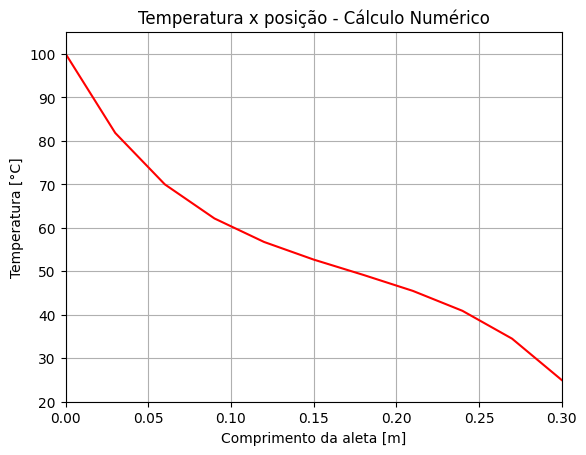

In [239]:
# Plot do gráfico - Solução Analítica
fig, ax = plt.subplots()
ax.plot(posicao, T_numerica, color="red")
ax.set(xlabel='Comprimento da aleta [m]', ylabel='Temperatura [°C]',
       title='Temperatura x posição - Cálculo Numérico')
plt.grid()
ax.set_ylim(ymin=20, ymax=t_base+5)
ax.set_xlim(xmin=0, xmax=0.3)
fig.savefig("TemperaturaxPosicao-Numerico.png")
plt.show()

## Questão 3

Solução analítica e seu respectivo gráfico

Para a solução analítica, levando em consideração que as temperaturas da extremidade e da base da aleta foram especificadas, tomou-se como base a seguinte equação que descreve a distribuição de temperaturas ao longo da aleta:

$\frac{\theta}{\theta_b} = \frac{(\theta_L/\theta_b)senh \ mx + senh \ m(L - x)}{senh \ mL}$

Sabendo que:

$\theta = T - T_{\infty}$

Reescrevendo a equação:

$\frac{T - T_{\infty}}{\theta_b} = \frac{(\theta_L/\theta_b)senh \ mx + senh \ m(L - x)}{senh \ mL}$

Desta forma, temos que a temperatura em cada ponto pode ser dada por:

$T = \frac{((\theta_L/\theta_b)senh \ mx + senh \ m(L - x)) \cdot \theta_b}{senh \ mL} + T_{\infty}$


In [240]:
def sol_analitica():
    """
    Permite calcular a solução analítica do problema.
    --> Importante: Para o cálculo analítico, não é necessário calcular para vários instantes de tempo, 
                    pois ele já obtém o resultado em regime permanente.
    --> Para este problema, estaremos calculando para o caso em que a temperatura na extremidade é especificada.
    """
    
    # Lista para guardar as temperaturas em cada posição [°C]
    T = np.zeros(shape=(nx))

    # Define as condições de contorno
    T[0] = t_base
    T[nx-1] = t_extremidade
    
    # Constantes para os cálculos
    theta_L = t_extremidade - t_fluido
    theta_B = t_base - t_fluido
    m = sqrt((h_amb*p)/(k_mat*a))

    # Realizando o cálculo para cada posição do espaço
    for x in range(1, nx-1):
        numerador = ((theta_L / theta_B) * sinh(m * posicao[x])) + sinh(m * (comprimento - posicao[x]))
        denominador = sinh(m * comprimento)
        distribuicao_de_temperaturas = numerador / denominador
        theta = distribuicao_de_temperaturas * theta_B
        T[x] = theta + t_fluido

    return T

    

In [241]:
# Recebe resultado da solução analítica na estabilidade
T_analitica = sol_analitica()

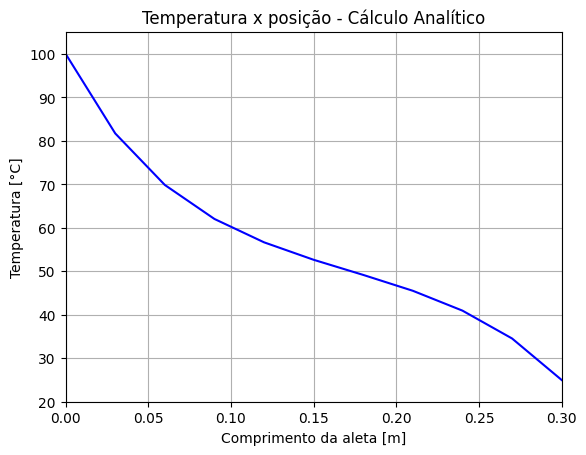

In [242]:
# Plot do gráfico - Solução Analítica
fig, ax = plt.subplots()
ax.plot(posicao, T_analitica, color="blue")
ax.set(xlabel='Comprimento da aleta [m]', ylabel='Temperatura [°C]',
       title='Temperatura x posição - Cálculo Analítico')
plt.grid()
ax.set_ylim(ymin=20, ymax=t_base+5)
ax.set_xlim(xmin=0, xmax=0.3)
fig.savefig("TemperaturaxPosicao-Analitico.png")
plt.show()

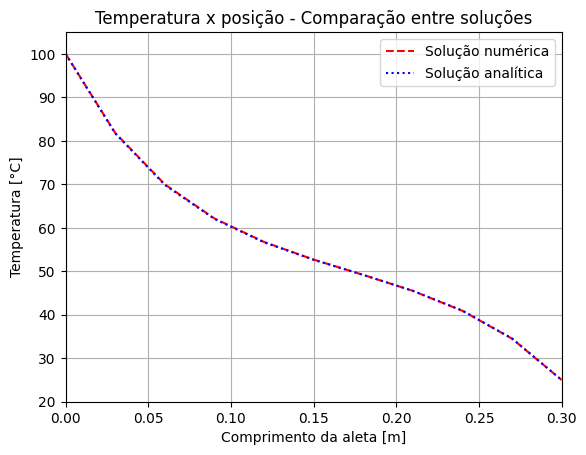

In [243]:
# Plot do gráfico de comparação entre as soluções Analítica
fig, ax = plt.subplots()
ax.plot(posicao, T_numerica, color="red", linestyle="dashed", label="Solução numérica")
ax.plot(posicao, T_analitica, color="blue", linestyle="dotted", label="Solução analítica")
ax.set(xlabel='Comprimento da aleta [m]', ylabel='Temperatura [°C]',
       title='Temperatura x posição - Comparação entre soluções')
plt.grid()
ax.set_ylim(ymin=20, ymax=t_base+5)
ax.set_xlim(xmin=0, xmax=0.3)
plt.legend()
fig.savefig("TemperaturaxPosicao-Comparativo.png")
plt.show()